In [ ]:
import sys
!{sys.executable} -m spacy download en_core_web_sm
!{sys.executable} -m spacy link en_core_web_sm en

## Topic Modeling LSA/I, probabilistic LSA / NMF and LDA

### Imports

In [9]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [10]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [11]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        file_id = file_name.split('.')[0]
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [12]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


### Inspect results

In [13]:
docs.sample(10)

,topic,heading,article
245,entertainment,Dirty Den's demise seen by 14m,"More than 14 million people saw ""Dirty"" Den W..."
2106,tech,Nintendo DS aims to touch gamers,The mobile gaming industry is set to explode ...
437,business,China Aviation seeks rescue deal,Scandal-hit jet fuel supplier China Aviation ...
904,sport,Robben sidelined with broken foot,Chelsea winger Arjen Robben has broken two me...
2008,tech,File-swappers ready new network,Legal attacks on websites that help people sw...
1220,sport,El Guerrouj targets cross country,Double Olympic champion Hicham El Guerrouj is...
291,entertainment,'My memories of Marley...',To mark the 60th anniversary of the birth of ...
917,sport,Injury doubts beset Wales squad,Wales have a clutch of injury worries before ...
911,sport,Hewitt falls to Dent in Adelaide,Lleyton Hewitt suffered a shock defeat to Tay...
1209,sport,Mirza shocks Kuznetsova,Sania Mirza continued her remarkable rise wit...


In [14]:
# word count
docs.article.str.split().str.len().sum()

842910

### Data drawn from 5 different categories

In [15]:
docs.topic.value_counts(normalize=True)

sport           0.23
business        0.23
politics        0.19
tech            0.18
entertainment   0.17
Name: topic, dtype: float64

## Prepare Document-Term Matrix

In [16]:
print(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding

### Baseline document-term matrix

In [17]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [18]:
doc_term_matrix.shape

(2225, 29275)

### Inspect tokens

In [19]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

### Inspect doc-term matrix

In [20]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Most frequent terms

In [21]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int64

### Compute relative term frequency

In [22]:
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 29275)

In [23]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    docs.shape[0]).sort_values(ascending=False).head(10)

the    1.00
to     1.00
of     0.99
and    0.99
in     0.99
for    0.93
on     0.91
is     0.86
it     0.86
said   0.85
dtype: float64

### Visualize Doc-Term Matrix

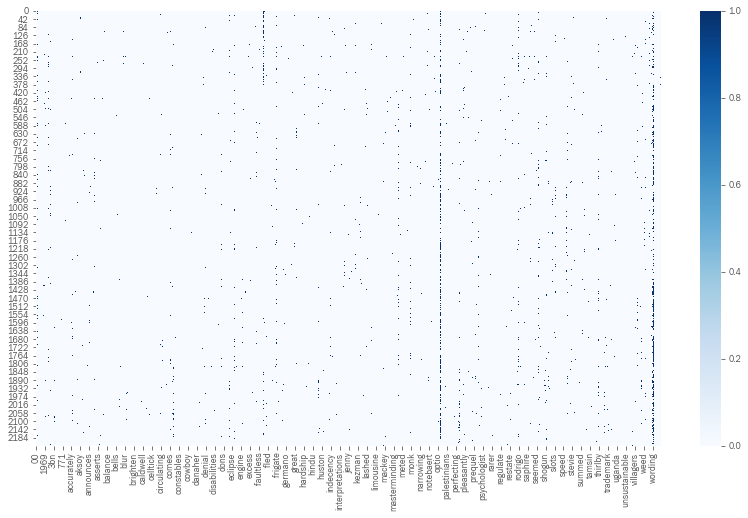

In [24]:
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8);

### Using thresholds to reduce the number of tokens 

In [25]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 12789)

### Use CountVectorizer with Lemmatization

#### Building a custom `tokenizer` for Lemmatization with `spacy`

In [26]:
nlp = spacy.load('en')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) 
                if not w.is_punct | w.is_space]

In [27]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 25073)

In [28]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

from     0.70
but      0.73
as       0.74
by       0.77
at       0.79
with     0.82
that     0.83
say      0.88
's       0.90
on       0.91
for      0.93
have     0.97
in       0.99
and      0.99
of       0.99
a        0.99
-PRON-   1.00
to       1.00
be       1.00
the      1.00
dtype: float64

Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

### TfIdf Vectorizer 

In [29]:
print(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf of term t is
    tf-idf(d, t) = tf(t) * idf(d, t), and the idf is computed as
    idf(d, t) = log [ n / df(d, t) ] + 1 (if ``smooth_idf=False``),
    where n is the total number of documents and df(d, t) is the
    document frequency; the document frequency is the number of documents d
    that contain term t. The effect of addi

In [30]:
tfidf = TfidfVectorizer()
doc_term_matrix = tfidf.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 29275)

In [31]:
words = tfidf.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=words)
word_freq_1d.sort_values().tail(20) 

are     53.42
have    54.73
as      55.83
has     56.23
with    57.27
will    57.99
be      63.05
was     68.57
on      75.63
said    78.80
it      79.05
he      79.85
that    82.59
is      84.27
for     84.30
in     165.16
and    166.06
of     177.76
to     221.14
the    475.64
dtype: float64

## Create Train & Test Sets

In [32]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [33]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [34]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
politics          9
entertainment     9
tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

In [35]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178873 stored elements in Compressed Sparse Row format>

In [36]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in Compressed Sparse Row format>

## Latent Semantic Analysis

In [37]:
svd = TruncatedSVD(n_components=5, n_iter=20, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=20,
       random_state=42, tol=0.0)

### Explore Topics 

In [38]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 6)]

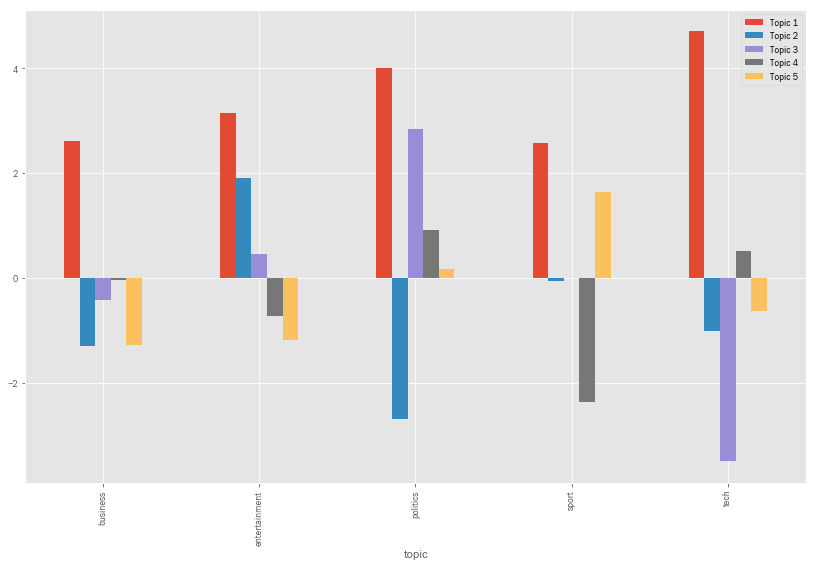

In [39]:
svd_result = pd.DataFrame(data=svd.transform(train_dtm),
                   columns=topic_labels,
                   index=train_docs.topic)
svd_result.groupby(level='topic').mean().plot.bar();

In [40]:
topics = pd.DataFrame(svd.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.07,-0.00,-0.01,-0.01,-0.01
100,0.02,-0.01,-0.02,0.01,-0.01
100m,0.00,0.00,0.00,-0.01,-0.00
11,0.03,-0.00,-0.00,-0.02,-0.02
12,0.03,-0.01,-0.02,-0.02,-0.00


In [41]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,music,best,labour,music,music
1,best,music,party,urban,game
2,think,song,best,labour,urban
3,good,25,election,party,games
4,song,awards,blair,election,england
5,game,robbie,brown,black,roddick
6,labour,urban,song,mobile,play
7,british,won,minister,blair,wales
8,games,film,kilroy,stone,black
9,mobile,award,prime,digital,party


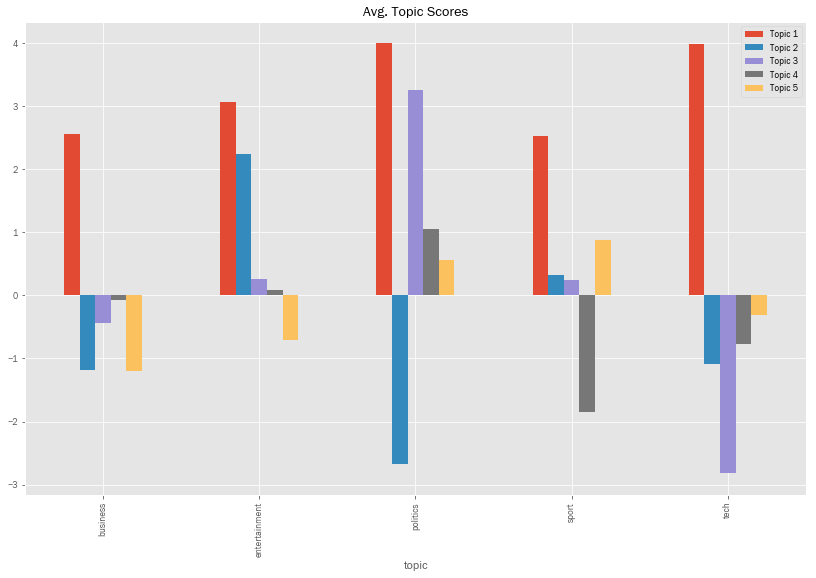

In [42]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Scores');

## probabilistic Latent Semantic Analysis

### Implementation using Non-Negative Matrix Factorization

pLSI [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.8839&rep=rep1&type=pdf) to be equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective.

In [43]:
nmf = NMF(n_components=5, random_state=42, solver='mu',
          beta_loss='kullback-leibler', max_iter=1000)
nmf.fit(train_dtm)
nmf.reconstruction_err_

1168.6761144034633

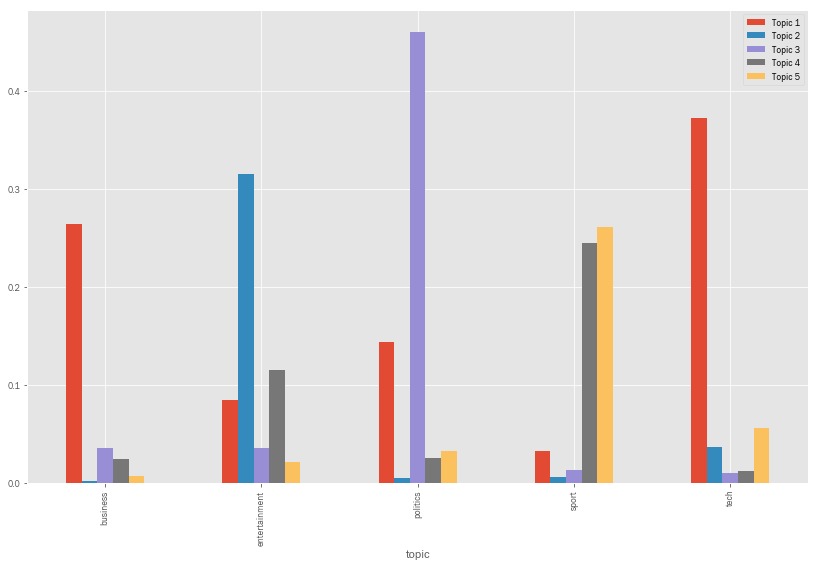

In [44]:
nmf_res = pd.DataFrame(data=nmf.transform(train_dtm),
                       columns=topic_labels,
                       index=train_docs.topic)
nmf_res.groupby(level='topic').mean().plot.bar();

In [45]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,1.02,0.00,0.00,0.72,0.00
100,0.51,0.00,0.00,0.00,0.00
100m,0.03,0.00,0.00,0.21,0.00
11,0.39,0.00,0.00,0.44,0.00
12,0.48,0.00,0.00,0.50,0.00


In [46]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,market,film,labour,second,game
1,company,best,election,final,england
2,says,music,party,won,games
3,work,awards,blair,win,play
4,use,award,minister,france,players
5,million,won,brown,open,wales
6,firm,band,public,best,club
7,2004,actor,howard,old,good
8,technology,director,britain,ireland,think
9,mobile,album,prime,international,half


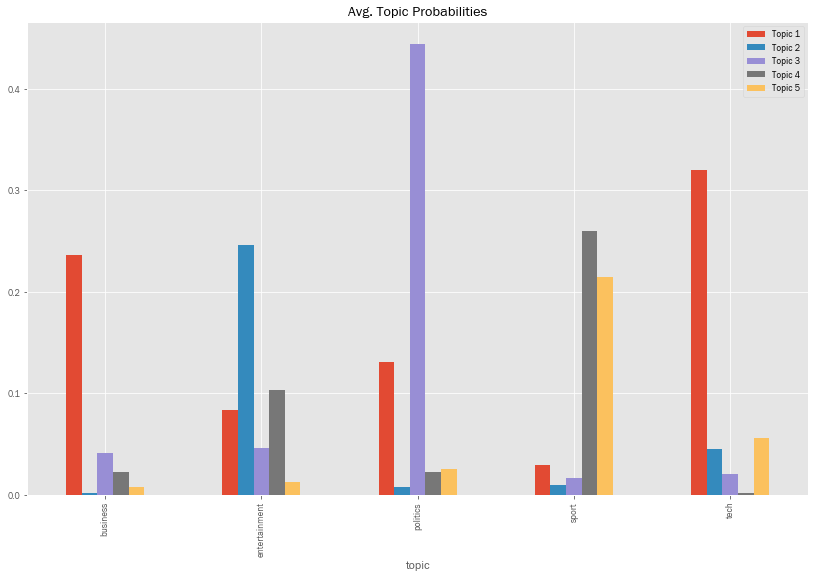

In [47]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(
    title='Avg. Topic Probabilities');

## Latent Dirichlet Allocation

### Simulate Dirichlet Distribution

In [48]:
f=FloatSlider(value=1, min=1e-2, max=1e2, step=1e-2, continuous_update=False, description='Alpha')
@interact(alpha=f)
def sample_dirichlet(alpha):
    topics = 10
    draws= 9
    alphas = np.full(shape=topics, fill_value=alpha)
    samples = np.random.dirichlet(alpha=alphas, size=draws)
    
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
    axes = axes.flatten()
    plt.setp(axes, ylim=(0, 1))
    for i, sample in enumerate(samples):
        axes[i].bar(x=list(range(10)), height=sample, color=sns.color_palette("Set2", 10))
    fig.suptitle('Dirichlet Allocation | 10 Topics, 9 Samples')
    fig.tight_layout()
    plt.subplots_adjust(top=.95)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Alpha', min=0.01, step=0.01…

### LDA with sklearn

In [49]:
lda_base = LatentDirichletAllocation(n_components=5,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Persist model

In [50]:
joblib.dump(lda_base, 'lda_models/lda_10_iter.pkl')

['lda_models/lda_10_iter.pkl']

In [51]:
lda_base = joblib.load('lda_models/lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Explore topics & word distributions

In [52]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 2000)


array([[ 88.43248684,  62.84277793,   0.21319435, ...,   0.20000057,
          0.20004305,   0.20009599],
       [ 85.35104168,  61.53801947,   2.50267928, ...,  59.19286646,
        180.19241591,   0.20684165],
       [162.77233486,  49.54588174,  12.00466794, ...,   0.20703568,
          0.20743611,   0.20240754],
       [168.96417848,  18.52681741,  36.07309077, ...,   0.20001305,
          0.20001283,  98.19064975],
       [ 39.47995814,  14.54650344,   0.20636766, ...,   0.20008424,
          0.20009211,   0.20000508]])

In [53]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00
100m,0.00,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,0.00
12,0.00,0.00,0.00,0.00,0.00


In [54]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

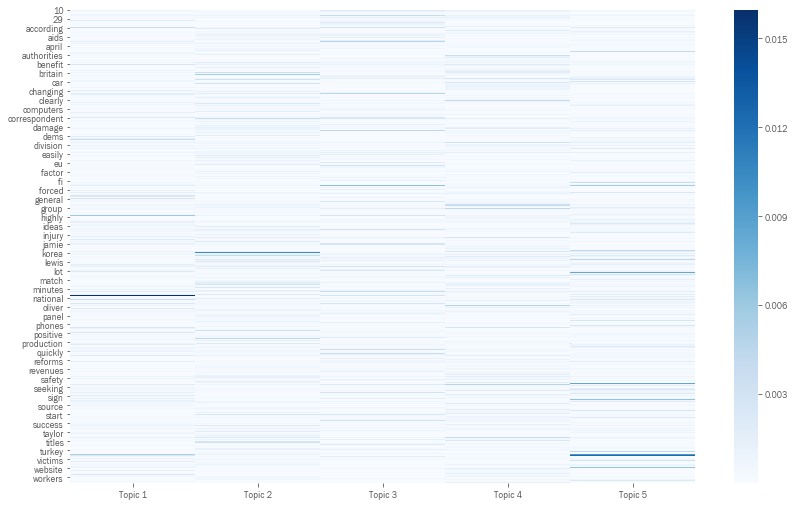

In [55]:
sns.heatmap(topics, cmap='Blues');

In [56]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,music,labour,market,best,software
1,mobile,election,company,film,users
2,technology,party,2004,game,information
3,digital,blair,sales,win,net
4,games,minister,growth,won,use
5,tv,public,bank,england,security
6,phone,brown,economy,play,mail
7,video,tax,firm,second,search
8,million,plans,economic,old,computer
9,high,say,oil,good,site


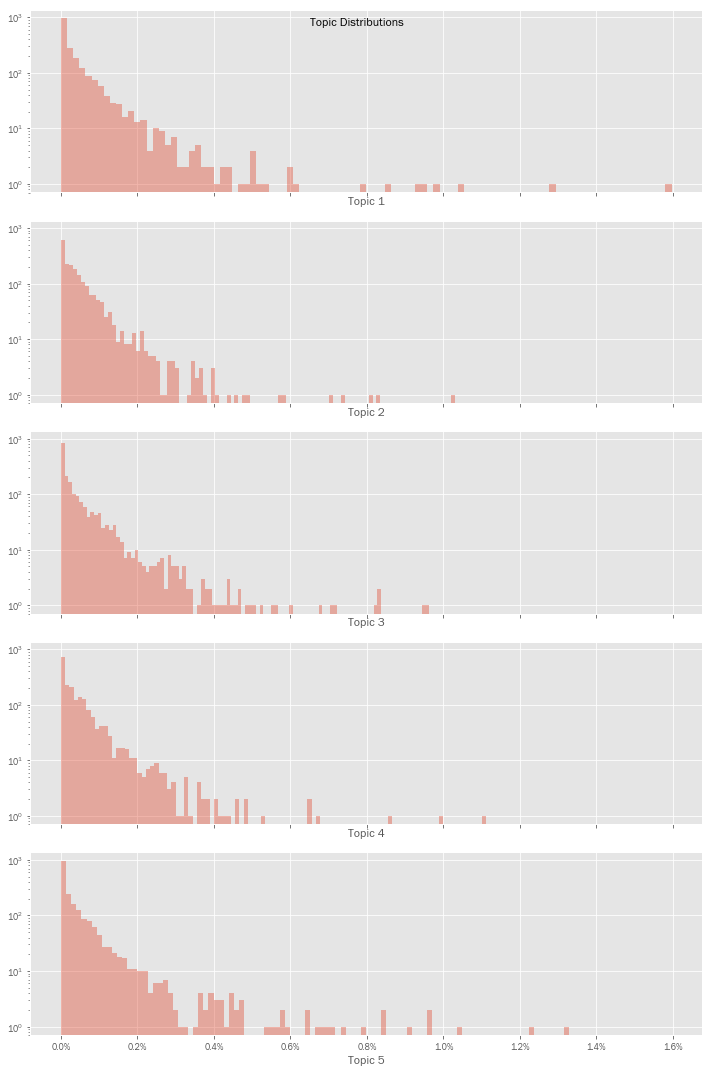

In [57]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

### Evaluate Fit on Train Set

In [58]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2175, 5)

In [59]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
entertainment,0.25,0.25,0.09,0.00,0.40
tech,0.07,0.42,0.00,0.00,0.51
entertainment,0.00,0.00,0.27,0.72,0.00
business,0.00,0.00,0.99,0.00,0.00
sport,0.03,0.00,0.00,0.94,0.03


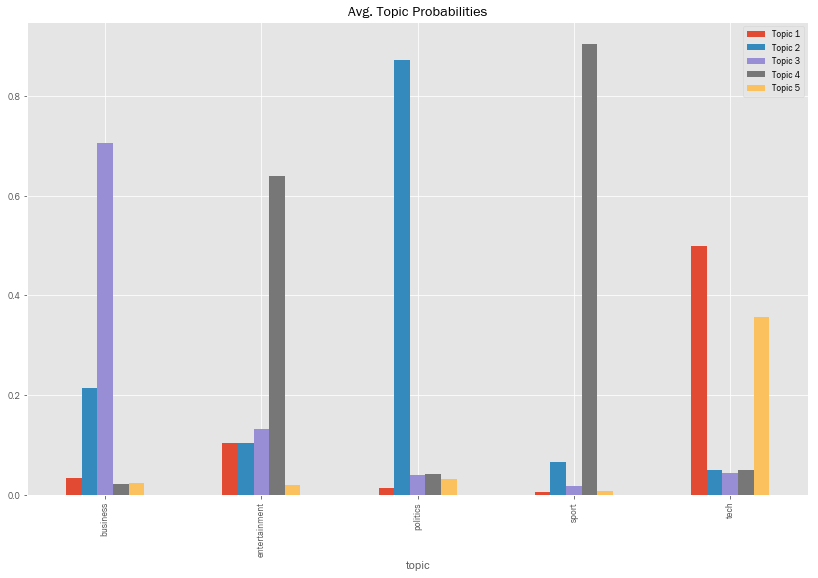

In [60]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

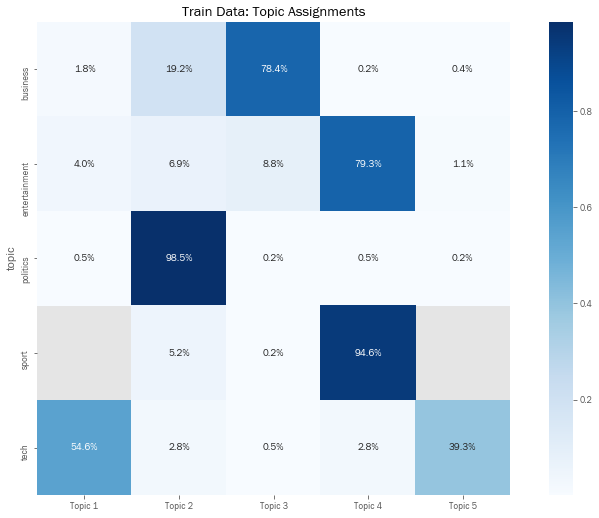

In [61]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

### Evaluate Fit on Test Set 

In [62]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
entertainment,0.34,0.08,0.45,0.00,0.13
tech,0.57,0.11,0.00,0.00,0.32
tech,0.65,0.00,0.00,0.26,0.08
business,0.00,0.09,0.90,0.00,0.00
sport,0.00,0.00,0.00,0.99,0.00


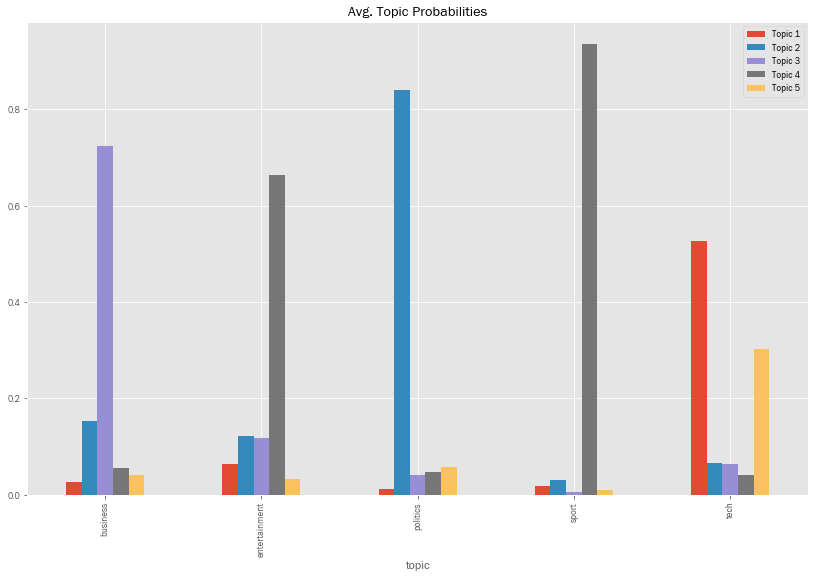

In [63]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

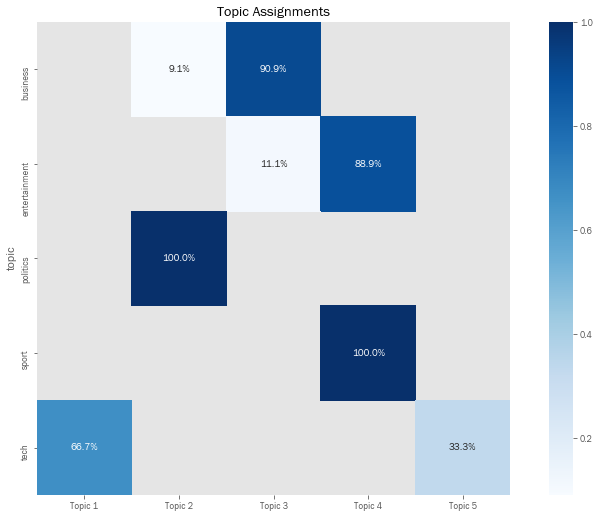

In [64]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

### Retrain until perplexity no longer decreases

In [65]:
lda_opt = LatentDirichletAllocation(n_components=5, 
                                    n_jobs=-1, 
                                    max_iter=500,
                                    learning_method='batch', 
                                    evaluate_every=5,
                                    verbose=1, 
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 1095.5312
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1065.9656
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1061.5272
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1058.7131
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1056.6675
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [ ]:
joblib.dump(lda_opt, 'lda_models/lda_opt.pkl')

In [ ]:
lda_opt = joblib.load('lda_models/lda_opt.pkl')

In [66]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [67]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

### Compare Train & Test Topic Assignments 

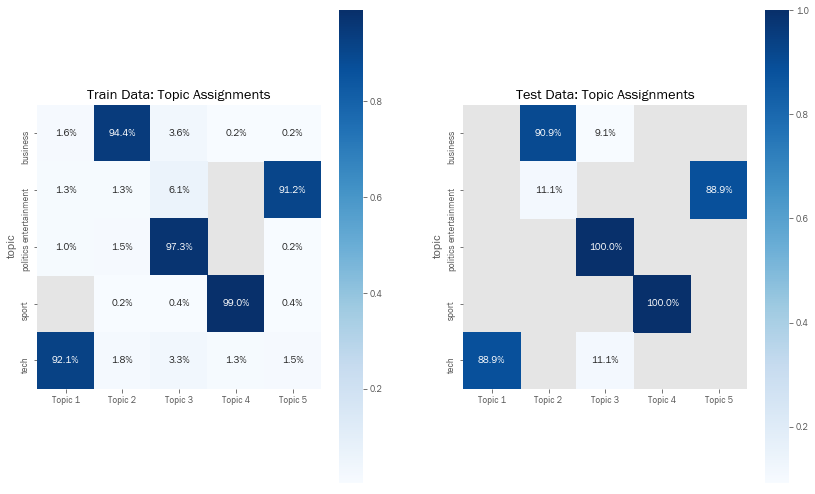

In [68]:
fig, axes = plt.subplots(ncols=2)
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

### Explore misclassified articles 

In [69]:
test_assignments = test_opt_eval.groupby(level='topic').idxmax(axis=1)
test_assignments = test_assignments.reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head()

,topic,predicted,heading,article
0,business,Topic 2,German music in a 'zombie' state,The German music business - the third largest...
1,business,Topic 2,Kenyan school turns to handhelds,At the Mbita Point primary school in western ...
2,business,Topic 2,Halo fans' hope for sequel,Xbox video game Halo 2 has been released in t...
3,business,Topic 2,Novartis hits acquisition trail,Swiss drugmaker Novartis has announced 5.65bn...
4,business,Topic 2,Radcliffe will compete in London,Paula Radcliffe will compete in the Flora Lon...


In [74]:
misclassified = test_assignments[(test_assignments.topic == 'business') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

6    Irish company hit by Iraqi report
Name: heading, dtype: object

In [75]:
misclassified.article.tolist()

[" Shares in Irish oil company Petrel Resources have lost more than 50% of their value on a report that the firm has failed to win a contract in Iraq.  Reuters news agency reported that Iraq's Oil Ministry has awarded the first post-war oilfield contracts to a Canadian and a Turkish company. By 1700 GMT, Petrel's shares fell from 97p ($1.87) to 44p ($0.85). Petrel said that it has not received any information from Iraqi authorities to confirm or deny the report.  Iraq is seeking to award contracts for three projects, valued at $500m (Â£258.5m). Turkey's Everasia is reported by Reuters to have won a contract to develop the Khurmala Dome field in the north of the country. A Canadian company, named IOG, is reported to have won the contract to run the Himrin field. Ironhorse Oil and Gas has denied to Reuters that it is the company in question. These two projects aim to develop Khurmala field to produce 100,000 barrels per day and raise the output of Himrin. The winners of the contract are 

### PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

#### Refit using all data

In [76]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [77]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1019.4411
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1005.7644
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1002.3647
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [78]:
joblib.dump(lda_all, 'lda_models/lda_all.pkl')

['lda_models/lda_all.pkl']

In [ ]:
lda_all = joblib.load('lda_models/lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [79]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=       Freq  cluster  topics     x     y
topic                                   
2     25.50        1       1  0.07  0.08
3     21.81        1       2  0.10 -0.10
0     20.95        1       3  0.14  0.02
4     18.68        1       4 -0.15  0.14
1     13.07        1       5 -0.16 -0.13, topic_info=     Category     Freq        Term    Total  loglift  logprob
term                                                         
1200  Default 2,987.00          mr 2,987.00    30.00    30.00
724   Default   838.00        film   838.00    29.00    29.00
230   Default   960.00        best   960.00    28.00    28.00
1022  Default   770.00      labour   770.00    27.00    27.00
780   Default   855.00        game   855.00    26.00    26.00
817   Default 1,151.00  government 1,151.00    25.00    25.00
1206  Default   810.00       music   810.00    24.00    24.00
619   Default   630.00    election   630.00    23.00    23.00
1305  Default   624.00       party   624.00    22.00    22.00
1177  Default   521.00      mobile   521.00    21.00    21.00
1788  Default   553.00  technology   553.00    20.00    20.00
240   Default   551.00       blair   551.00    19.00    19.00
631   Default   593.00     england   593.00    18.00    18.00
1319  Default 2,030.00      people 2,030.00    17.00    17.00
1129  Default   683.00      market   683.00    16.00    16.00
1884  Default   406.00       users   406.00    15.00    15.00
551   Default   404.00     digital   404.00    14.00    14.00
195   Default   291.00      awards   291.00    13.00    13.00
194   Default   280.00       award   280.00    12.00    12.00
1658  Default   373.00    software   373.00    11.00    11.00
205   Default   360.00        bank   360.00    10.00    10.00
832   Default   443.00      growth   443.00     9.00     9.00
1170  Default   552.00    minister   552.00     8.00     8.00
1329  Default   373.00       phone   373.00     7.00     7.00
1968  Default   589.00         won   589.00     6.00     6.00
403   Default   678.00     company   678.00     5.00     5.00
1346  Default   513.00     players   513.00     4.00     4.00
1957  Default   580.00         win   580.00     3.00     3.00
380   Default   364.00        club   364.00     2.00     2.00
608   Default   421.00     economy   421.00     1.00     1.00
...       ...      ...         ...      ...      ...      ...
387    Topic5   130.06      comedy   131.91     2.02    -5.66
724    Topic5   818.47        film   838.11     2.01    -3.82
1661   Topic5   171.90        song   177.54     2.00    -5.38
204    Topic5   211.33        band   223.18     1.98    -5.17
71     Topic5    81.95     academy    84.31     2.01    -6.12
1395   Topic5   148.72       prize   158.69     1.97    -5.52
325    Topic5   102.17    ceremony   107.12     1.99    -5.90
1705   Topic5   127.00       stars   137.86     1.95    -5.68
1703   Topic5   249.08        star   292.57     1.87    -5.01
230    Topic5   696.54        best   960.17     1.71    -3.98
316    Topic5    96.61    category   102.16     1.98    -5.96
725    Topic5   210.99       films   254.02     1.85    -5.18
1456   Topic5   101.42         ray   108.11     1.97    -5.91
1206   Topic5   404.25       music   810.45     1.34    -4.52
1194   Topic5   127.99       movie   158.77     1.82    -5.67
1968   Topic5   290.74         won   589.22     1.33    -4.85
556    Topic5   230.02    director   426.78     1.42    -5.09
266    Topic5   224.15     british   533.07     1.17    -5.11
920    Topic5   183.01   including   404.97     1.24    -5.32
1238   Topic5   228.82      number   748.61     0.85    -5.09
1992   Topic5   233.01       years   991.66     0.59    -5.08
1863   Topic5   177.81          tv   481.87     1.04    -5.35
1224   Topic5   288.40         new 1,896.89     0.15    -4.86
1866   Topic5   211.82          uk 1,047.96     0.44    -5.17
216    Topic5   164.20         bbc   747.90     0.52    -5.43
1081   Topic5   144.30      london   454.66     0.89    -5.55
1816   Topic

### Topics as WordClouds

In [80]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

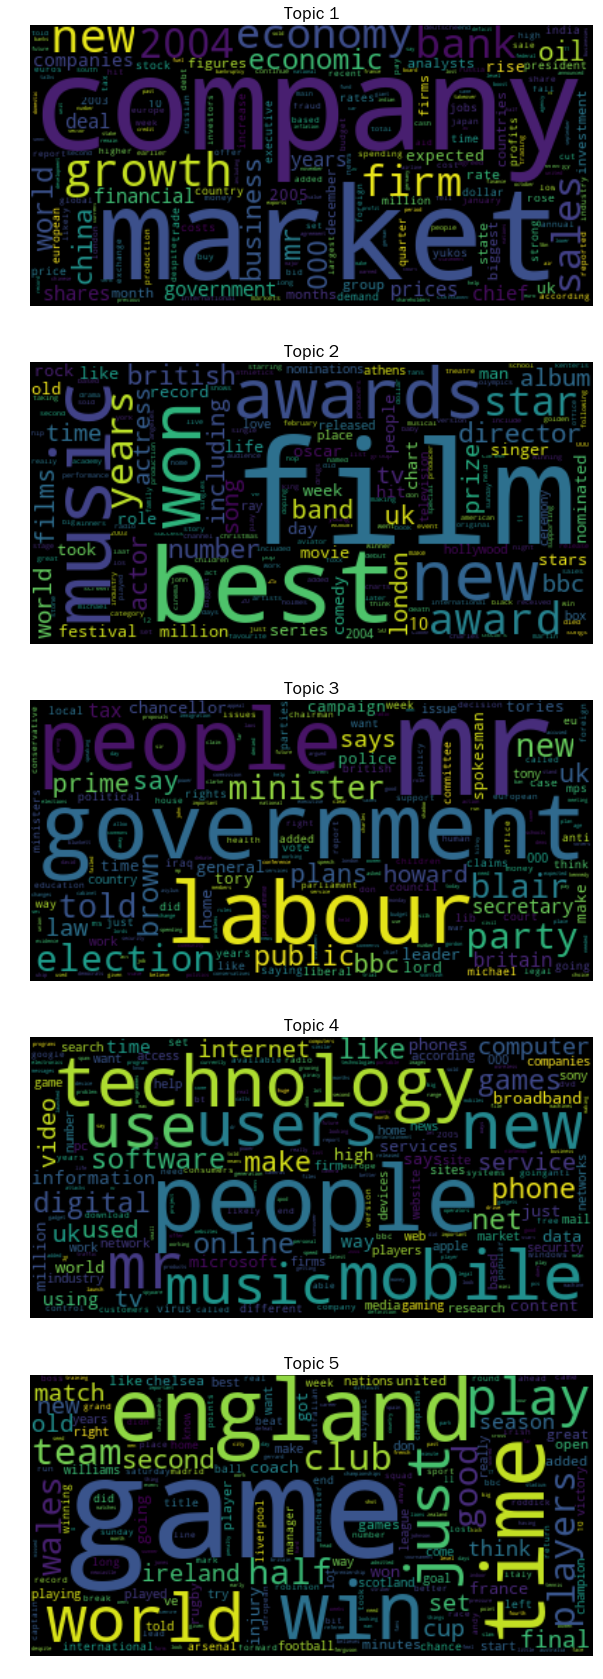

In [81]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [82]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [83]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [84]:
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.1).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
entertainment,0.15,0.28,0.23,0.23,0.11,Women in the UK film industry earn less than ...,Women in film 'are earning less'


In [85]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)
    ®
print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Women in film 'are earning less' 

Women in the UK film industry earn less than their male counterparts despite being better qualified, according to a study released on Wednesday. Only 16% of women earn more than Â£50,000, compared with 30% of men. Women make up a third of the workforce. The research was carried out jointly by the UK Film Council and industry training body Skillset. It also found that women in the industry were less likely than men to be married or have dependant children. The study, which claims to be the most in-depth so far conducted, found 60% of women in the film industry hold degrees, compared with 39% of men. Whilst 17% of men in the industry had no qualifications, this was true for only five per cent of women. In the lower salary bracket, 35% of women earn less than Â£20,000 a year, compared to only 18% of men. The research found very few women worked in the camera, sound, electrical and construction departments, but th

## LDA with gensim

### Using `CountVectorizer` Input

In [86]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()

In [87]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

In [88]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)

id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

### Train Model & Review Results

In [89]:
lda_gensim = LdaModel(corpus=train_corpus,
                          num_topics=5,
                          id2word=id2word)

In [90]:
topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.016*"best" + 0.009*"united" + 0.008*"glazer" + 0.007*"club" + 0.006*"film" + 0.005*"game" + 0.004*"women" + 0.004*"award" + 0.004*"awards" + 0.004*"won"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [91]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

  Topic 1           Topic 2           Topic 3        Topic 4          Topic 5        
     prob      term    prob      term    prob   term    prob     term    prob    term
0   0.87%    labour   0.71%      lord   0.68%   game   0.80%     game   1.56%    best
1   0.70%  election   0.57%      home   0.58%   play   0.54%      win   0.90%  united
2   0.66%     brown   0.56%     music   0.58%   film   0.46%      won   0.81%  glazer
3   0.66%       tax   0.45%  internet   0.53%  music   0.46%     half   0.71%    club
4   0.56%   economy   0.44%   digital   0.50%  games   0.45%  england   0.58%    film


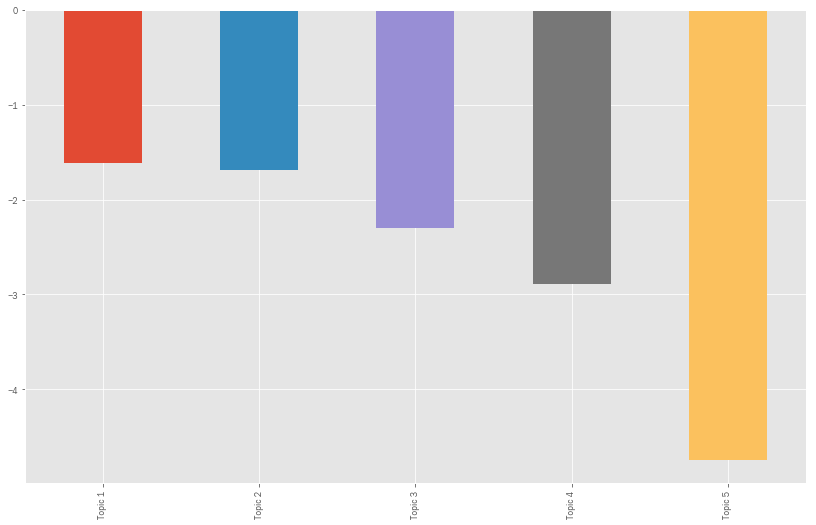

In [92]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
print(topic_words.head())
pd.Series(topic_coherence, index=topic_labels).plot.bar();

### Using `gensim` `Dictionary` 

In [93]:
docs = [d.split() for d in train_docs.article.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

In [94]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [95]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [96]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 2175


In [97]:
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [98]:
%%time
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

CPU times: user 27 s, sys: 153 ms, total: 27.2 s
Wall time: 27.3 s


In [99]:
model.show_topics()

[(0,
  '0.017*"music" + 0.012*"mobile" + 0.010*"games" + 0.010*"digital" + 0.009*"game" + 0.009*"technology" + 0.009*"video" + 0.006*"TV" + 0.006*"phones" + 0.005*"play"'),
 (1,
  '0.019*"best" + 0.013*"film" + 0.011*"won" + 0.009*"British" + 0.007*"world" + 0.006*"years" + 0.005*"director" + 0.005*"star" + 0.005*"band" + 0.005*"took"'),
 (2,
  '0.007*"government" + 0.006*"market" + 0.006*"economic" + 0.006*"company" + 0.006*"growth" + 0.006*"economy" + 0.005*"sales" + 0.005*"chief" + 0.005*"rise" + 0.005*"oil"'),
 (3,
  '0.010*"use" + 0.009*"used" + 0.008*"users" + 0.007*"net" + 0.007*"information" + 0.007*"using" + 0.006*"phone" + 0.006*"security" + 0.006*"software" + 0.006*"internet"'),
 (4,
  '0.008*"Labour" + 0.006*"Blair" + 0.005*"government" + 0.005*"England" + 0.005*"Brown" + 0.005*"game" + 0.005*"think" + 0.005*"election" + 0.004*"say" + 0.004*"going"')]

### Evaluating Topic Assignments on the Test Set

In [100]:
docs_test = [d.split() for d in test_docs.article.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

In [101]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4
0,71.45,0.08,67.68,18.06,0.09
1,29.29,0.08,0.09,85.82,0.09
2,132.59,18.76,0.09,5.83,0.09
3,2.27,1.62,65.33,0.05,0.09
4,0.05,67.48,0.09,0.05,18.69
5,0.05,0.08,67.09,0.05,0.09
6,0.05,11.09,57.60,0.05,11.57
7,0.05,34.73,0.09,0.05,45.44
8,0.05,0.08,55.36,0.05,7.82
9,0.05,0.08,47.09,0.05,0.09


In [102]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4
0,0.45,0.00,0.43,0.11,0.00
1,0.25,0.00,0.00,0.74,0.00
2,0.84,0.12,0.00,0.04,0.00
3,0.03,0.02,0.94,0.00,0.00
4,0.00,0.78,0.00,0.00,0.22


In [103]:
topic_probabilities.idxmax(axis=1).head()

0    0
1    3
2    0
3    2
4    1
dtype: int64

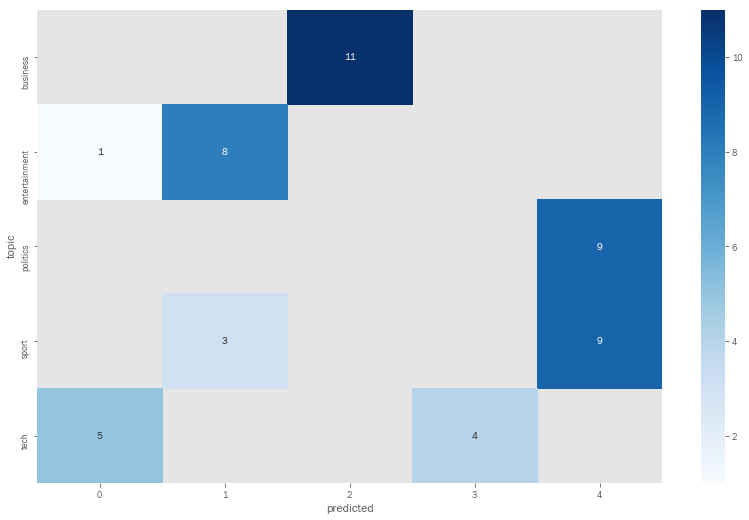

In [106]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');

## Resources

- pyLDAvis: 
    - [Talk by the Author](https://speakerdeck.com/bmabey/visualizing-topic-models) and [Paper by (original) Author](http://www.aclweb.org/anthology/W14-3110)
    - [Documentation](http://pyldavis.readthedocs.io/en/latest/index.html)
- LDA:
    - [David Blei Homepage @ Columbia](http://www.cs.columbia.edu/~blei/)
    - [Introductory Paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) and [more technical review paper](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf)
    - [Blei Lab @ GitHub](https://github.com/Blei-Lab)
    
- Topic Coherence:
    - [Exploring Topic Coherence over many models and many topics](https://www.aclweb.org/anthology/D/D12/D12-1087.pdf)
    - [Paper on various Methods](http://www.aclweb.org/anthology/N10-1012)
    - [Blog Post - Overview](http://qpleple.com/topic-coherence-to-evaluate-topic-models/)
